In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
inferno_r = matplotlib.cm.inferno_r
cmap = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)

In [3]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = '_elementary'
mass_multiplier = 1e10
log_mass_shift = 10

In [4]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/scalar_TNG100-1_elementary.yaml


In [5]:
with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

# Load in objects; need no matter what feature type
sim_reader = SimulationReader(halo_params['sim']['base_dir'], halo_params['sim']['sim_name'], 
                              halo_params['sim']['sim_name_dark'], halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(halo_params['halo']['fn_dark_halo_arr'])
sim_reader.read_simulations() # TODO: do we need this step?

In [6]:
x_scalars, x_scalars_extra = utils.load_features('scalars', sim_reader, fn_scalar_config=fn_scalar_config)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features
loading scalar features
loaded


In [7]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

In [8]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

# Tests

### Baseline

In [66]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [74]:
fit_tag = f'_dropout_batchnorm_{y_label_name}_nn_catalog_z0_epochs1500_lr0.0005_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

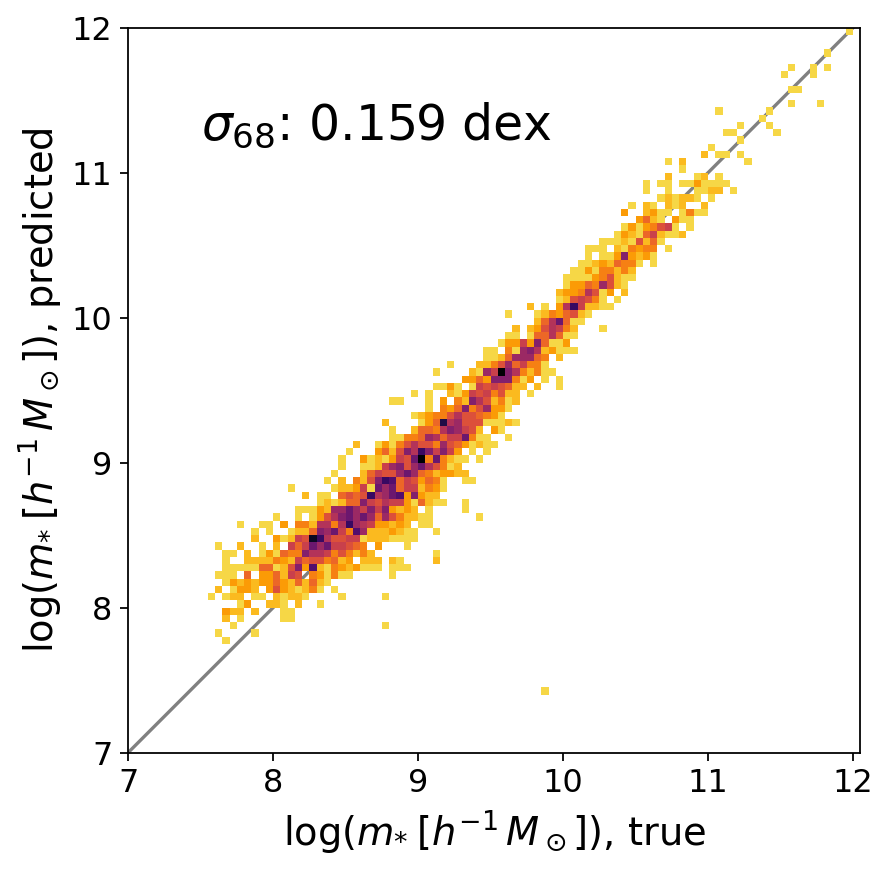

In [75]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)

973 0.7697318666943846


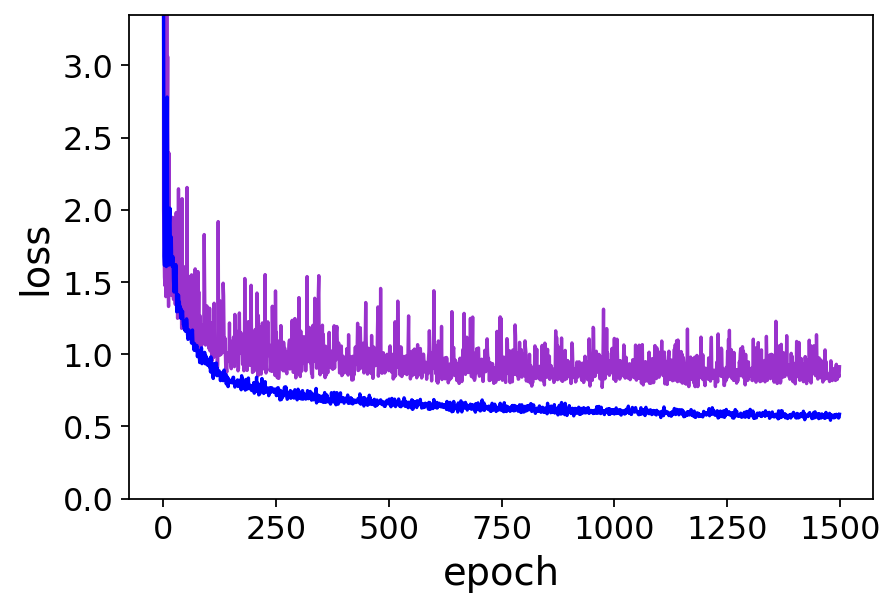

In [76]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(0, nnfitter.loss_train[1])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

### with 6 layers

In [9]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [11]:
fit_tag = f'_list_nl6_{y_label_name}_nn_catalog_z0_epochs1500_lr0.0001_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

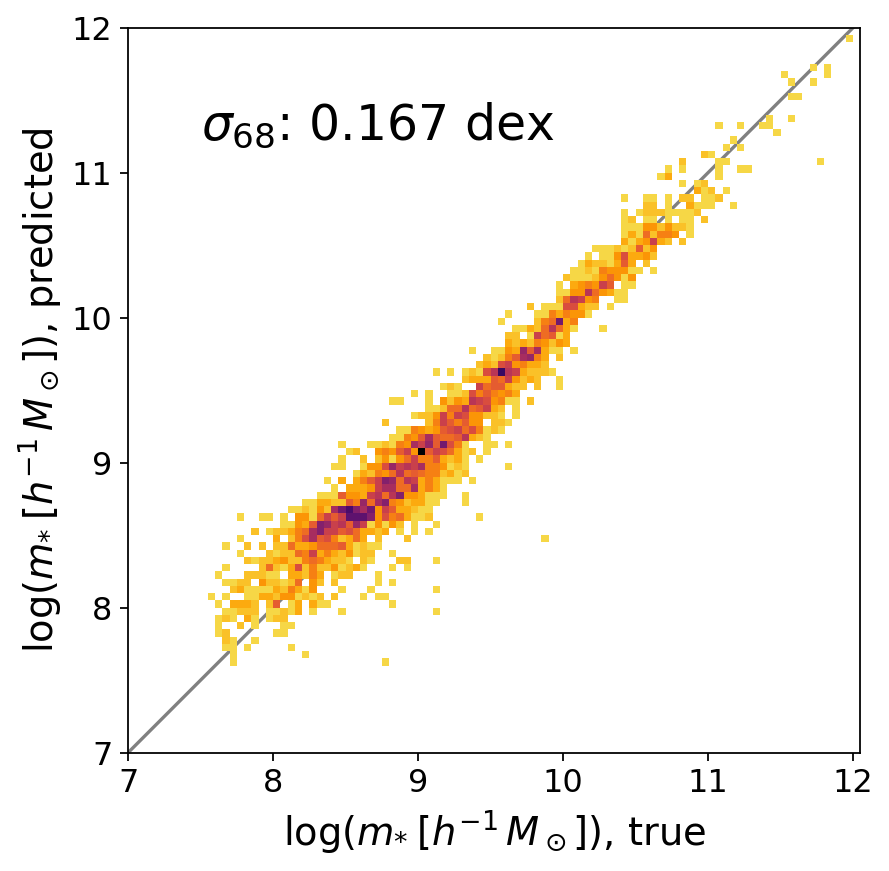

In [12]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)

642 0.8250601110262599


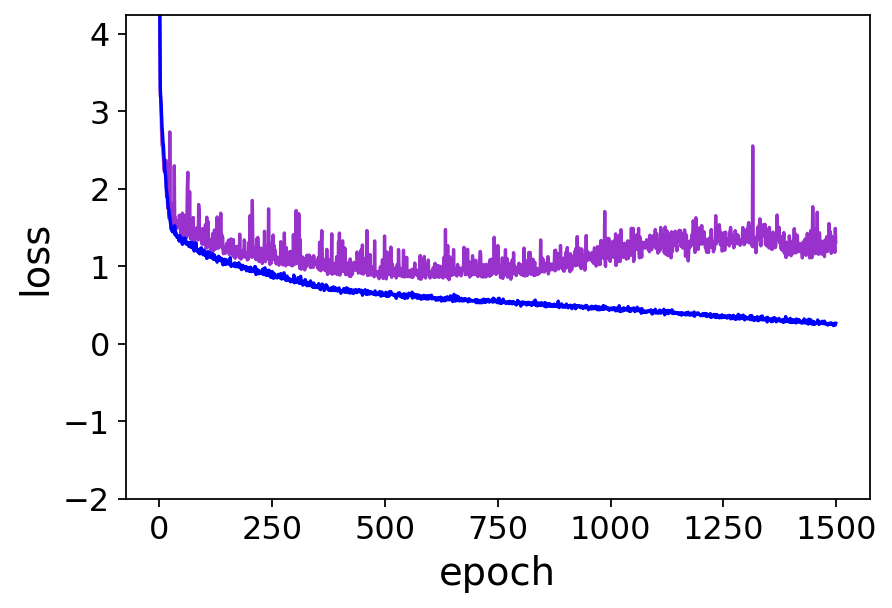

In [13]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-2, nnfitter.loss_train[1])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

### with 9 layers with batchnorm

In [97]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [98]:
fit_tag = f'_list_nl9_bn_{y_label_name}_nn_catalog_z0_epochs1000_lr0.0001_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

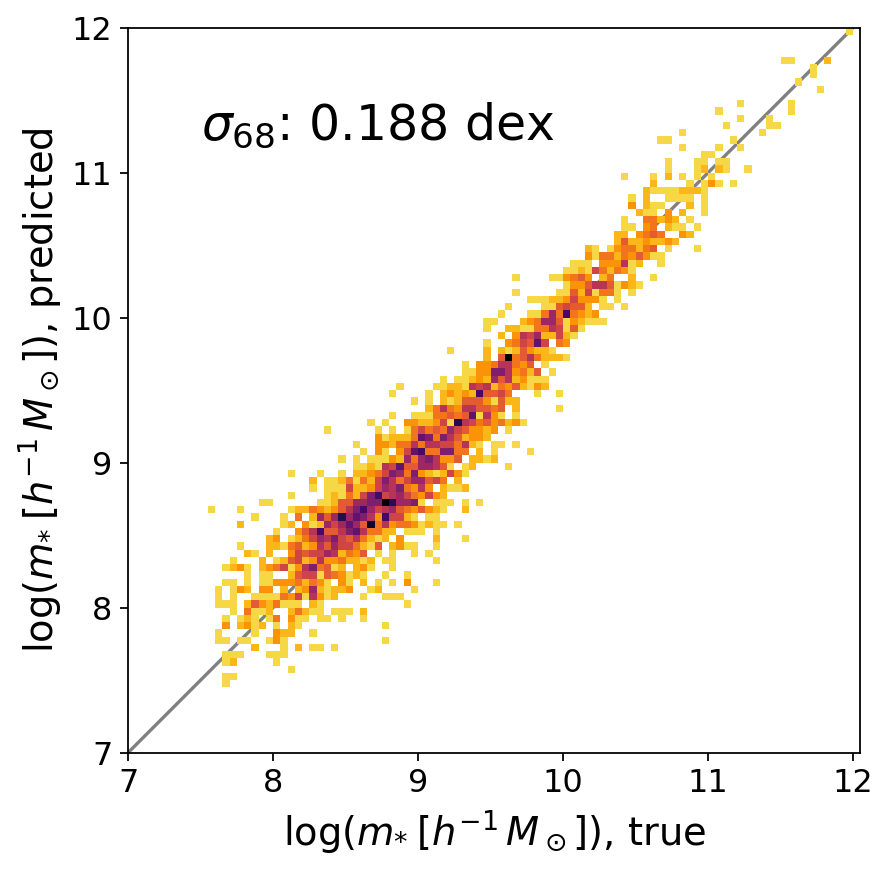

In [99]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)

92 0.9101997020256959


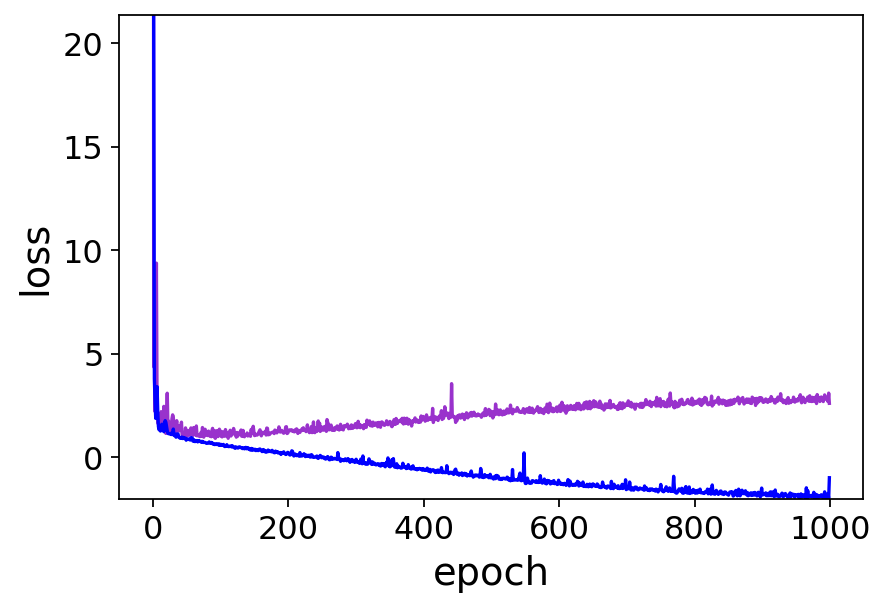

In [101]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-2, nnfitter.loss_train[1])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

# grad boost

In [102]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [112]:
fit_tag = f'_nest1000_{y_label_name}_gboost_catalog_z0_epochs1_lr0.1_hs128'
#fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

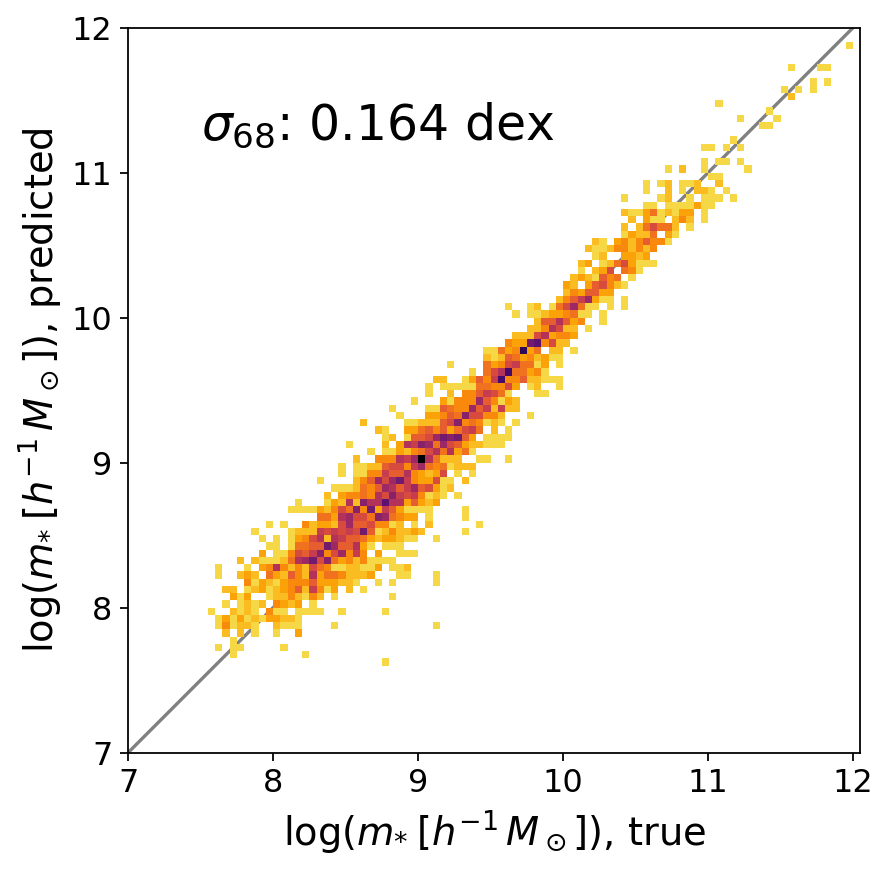

In [113]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)

# hist grad boost

In [85]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [91]:
fit_tag = f'_{y_label_name}_hgboost_catalog_z0_epochs1000_lr0.01_hs128'
#fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

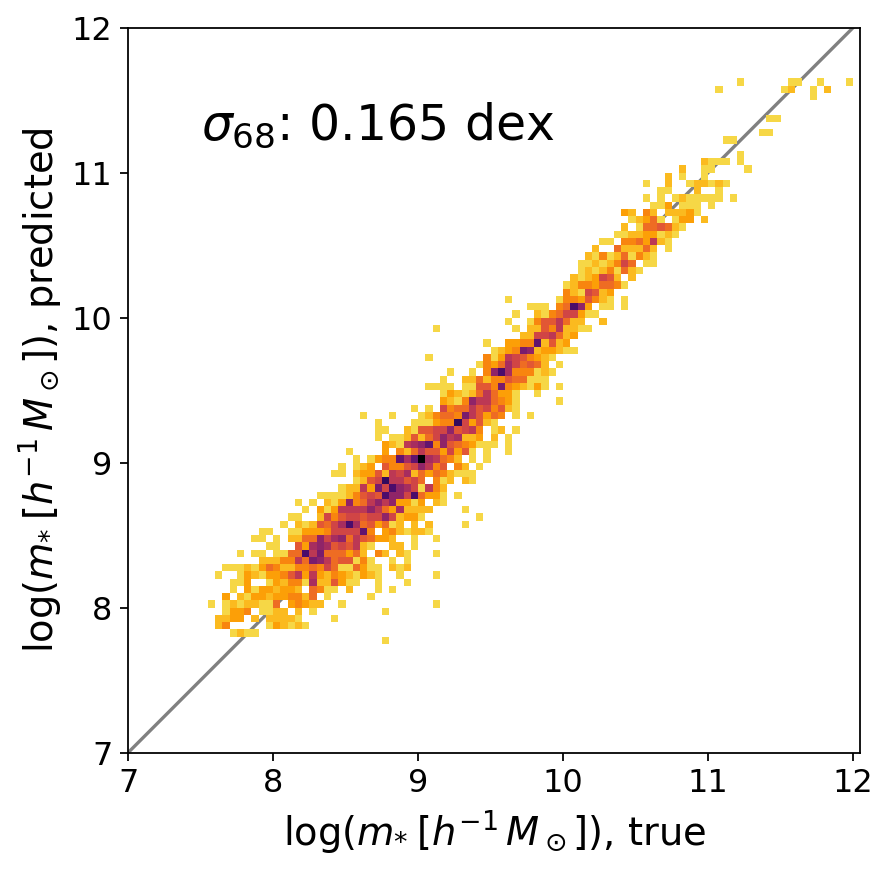

In [92]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)

## random forest

In [85]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [95]:
fit_tag = f'_nest300_{y_label_name}_rf_catalog_z0_epochs1_lr1_hs128'
#fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

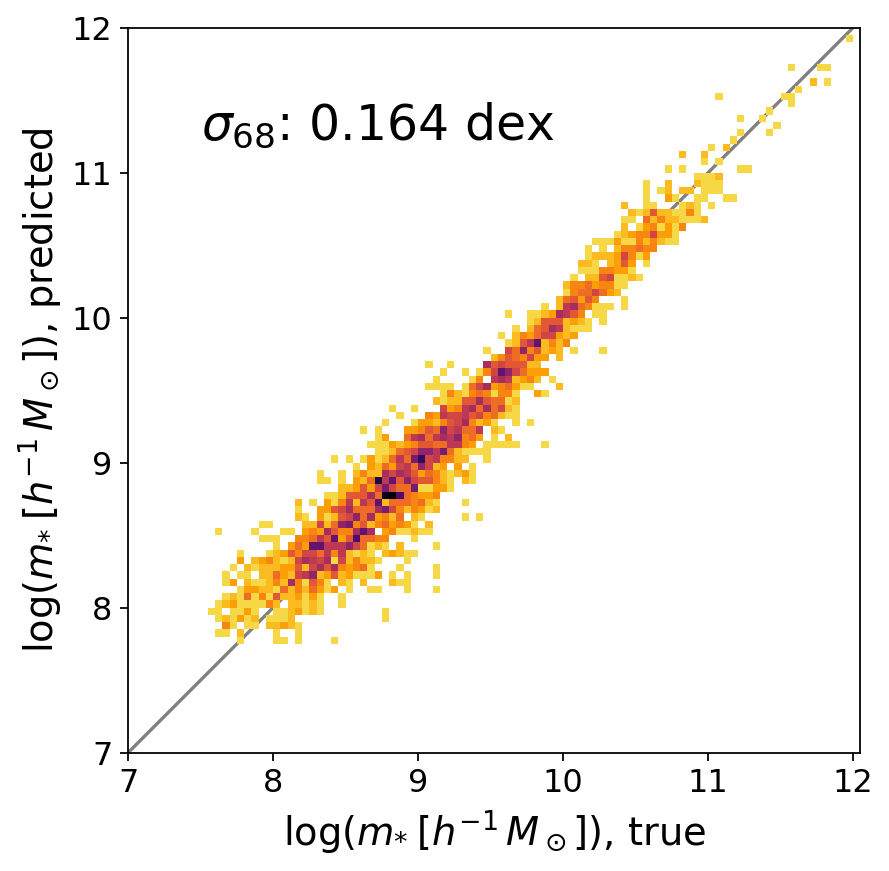

In [96]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)

# SCALARS elementary

# grad boost

In [29]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [30]:
fit_tag = f'_nest1000_elementary_{y_label_name}_gboost_scalars_epochs1_lr0.1_hs128'
#fit_tag = f'_nest500_elementary_{y_label_name}_gboost_scalars_epochs1_lr0.2_hs128'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

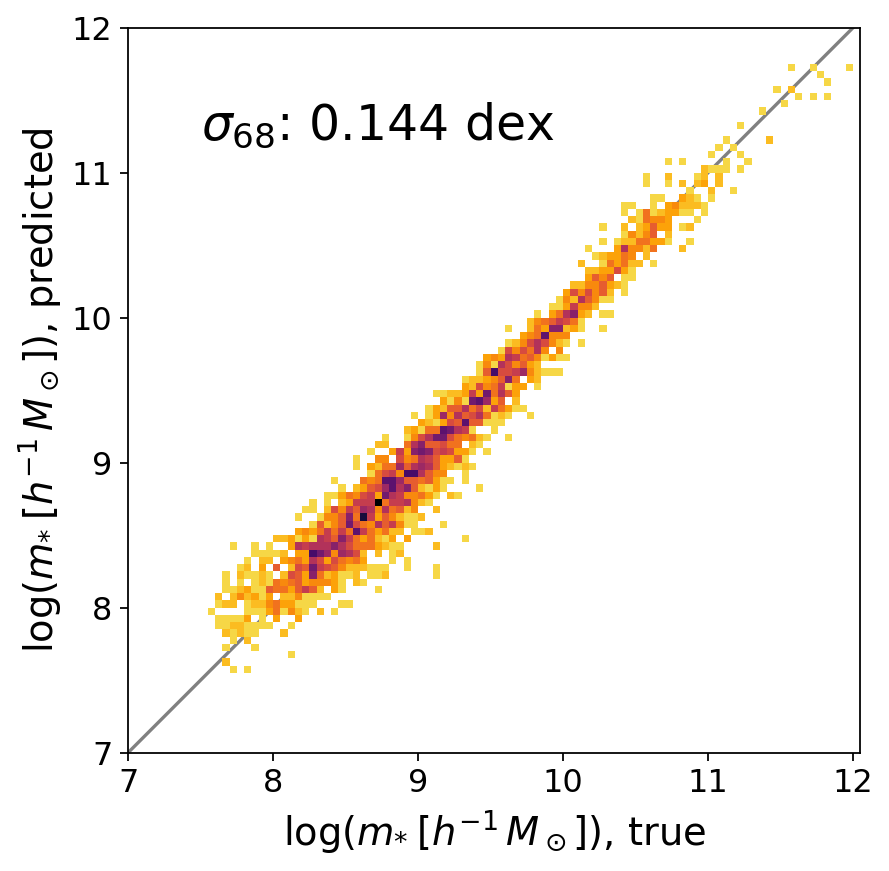

In [31]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)

# hist grad boost

In [17]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [20]:
fit_tag = f'_elementary_{y_label_name}_hgboost_scalars_epochs100_lr0.1_hs128'
#fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

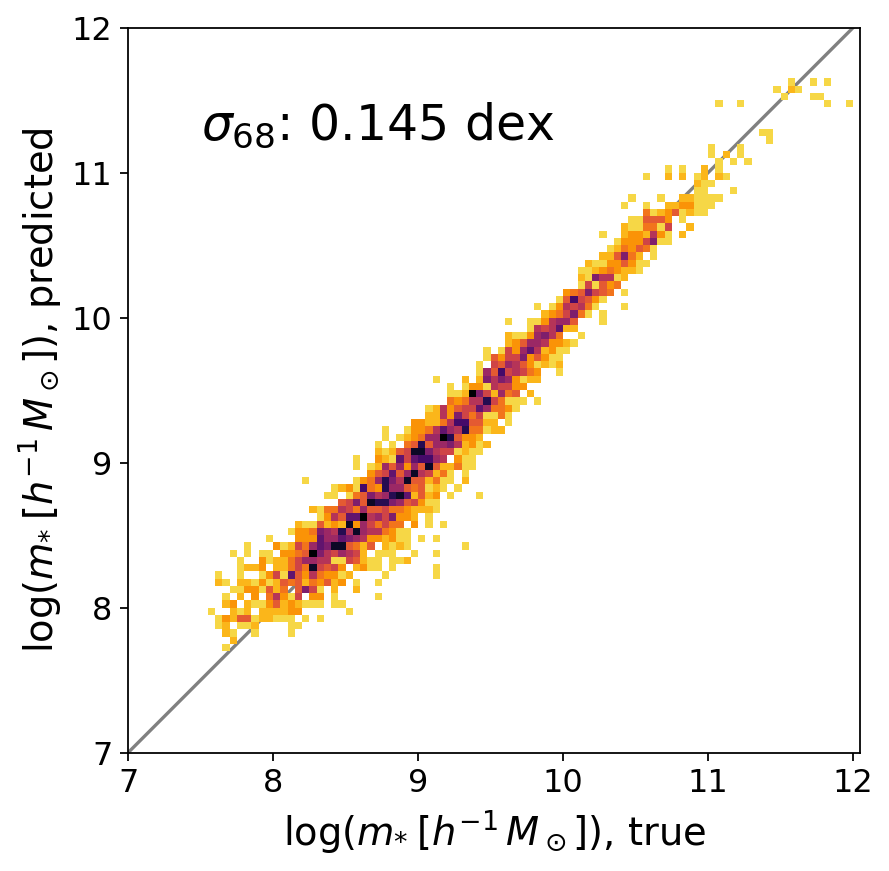

In [21]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)

## random forest

In [32]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [36]:
fit_tag = f'_nest300_elementary_{y_label_name}_rf_scalars_epochs1_lr1_hs128'
#fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

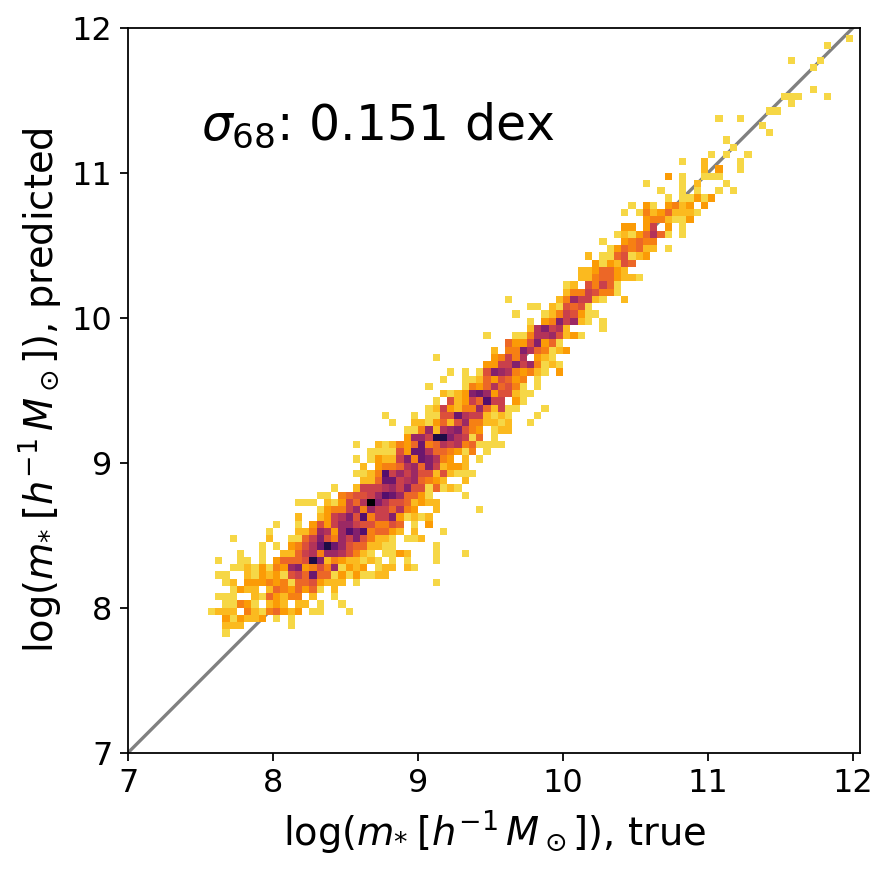

In [37]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)

# tabnet

In [9]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
x_property = log_m_200m[idx_test] + log_mass_shift

y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [22]:
fit_tag = f'_elementary_{y_label_name}_tabnet_scalars_epochs500_lr0.02_hs128'
#fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

y_pred = np.load(fn_pred)

y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

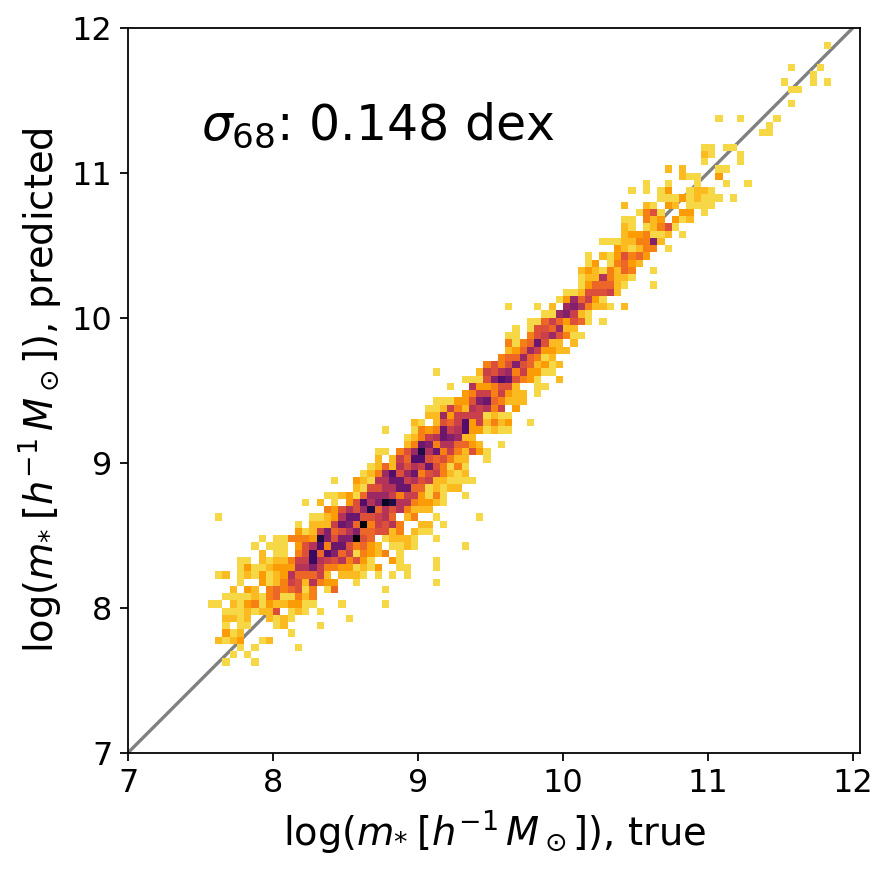

In [23]:
plt.figure(figsize=(6,6))
ax = plt.gca()
_ = plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred_mult, cmap, text_results=error_str)